In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import sys

In [2]:
path_transformer = os.path.abspath('..')
sys.path.append(path_transformer)
import opensense_data_downloader_and_transformer as oddt

# Derive small example dataset from the OpenMRG dataset from SMHI with large CML dataset
source: https://zenodo.org/record/6673751

In [3]:
oddt.download_andersson_2022_OpenMRG(local_path='andersson_2022_OpenMRG/', print_output=True)

File already exists at desired location andersson_2022_OpenMRG/OpenMRG.zip
Not downloading!


In [4]:
ds = oddt.transform_andersson_2022_OpenMRG(
    fn='andersson_2022_OpenMRG/OpenMRG.zip', 
    path_to_extract_to='data/andersson_2022_OpenMRG/',
    time_start_end = ('2015-08-27T00', '2015-08-28T00'), # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)

In [5]:
ds = ds.resample(time = '1T').first()

In [6]:
ds["tsl"] = ds.tsl.interpolate_na(dim="time", method="linear", max_gap="5min")
ds["rsl"] = ds.rsl.interpolate_na(dim="time", method="linear", max_gap="5min")

In [7]:

ds.to_netcdf(
    path='./openMRG_example.nc',
    encoding={
        'rsl': {
            'dtype': 'int32',
            'scale_factor': 0.01,
            '_FillValue': -9999,
            'zlib': True, 
            'complevel': 4},
        'tsl':{
            'dtype': 'int32',
            'scale_factor': 0.01,
            '_FillValue': -9999,
            'zlib': True, 
            'complevel': 4}
    }
)


In [8]:
# get short radar data for use case
ds_rad = xr.open_dataset('./andersson_2022_OpenMRG/radar/radar.nc').sel(
    time = slice('2015-08-27T01:00', '2015-08-27T02:30'))

In [9]:
def marshal_palmer(dBZ):
    return ( 10 **(dBZ/10) / 200)**(5/8)
ds_rad['rainfall'] = marshal_palmer(ds_rad.data)
ds_rad = ds_rad.drop('data')

In [10]:
ds_rad.to_netcdf('./openMRG_example_rad.nc')

# Tests:

### 1) test execution time
The two methods uses different approaches for structuring the datasets. This compares the execution time of the two methods. 

In [11]:
%%time
ds = oddt.transform_andersson_2022_OpenMRG(
    fn='andersson_2022_OpenMRG/OpenMRG.zip', 
    path_to_extract_to='andersson_2022_OpenMRG/',
    time_start_end = ('2015-08-27T00', '2015-08-28T00'), # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)

CPU times: user 12.1 s, sys: 3.04 s, total: 15.2 s
Wall time: 15.6 s


In [12]:
%%time
ds_linkbylink = oddt.transform_andersson_2022_OpenMRG_linkbylink(
    fn='andersson_2022_OpenMRG/OpenMRG.zip', 
    path_to_extract_to='andersson_2022_OpenMRG/',
    time_start_end = ('2015-08-27T00', '2015-08-28T00'), # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)

CPU times: user 19.4 s, sys: 7.25 s, total: 26.6 s
Wall time: 26.8 s


### 2) test matching data
The two datasets has the same structure, this test checks that the data contained in them are the same

In [13]:
# shorten so that time match ( for comparison ) 
ds = ds.sel(time = ds_linkbylink.time)

In [14]:
# check that they are equal
# rsl
is_not_nan = ~np.isnan(ds_linkbylink.rsl) # skip nan as nan generates False
if (ds.rsl.transpose('cml_id', 'sublink_id', 'time').values[is_not_nan] == ds_linkbylink.rsl.values[is_not_nan]).all():
    print('test passed')
# tsl
is_not_nan = ~np.isnan(ds_linkbylink.tsl)
if (ds.tsl.transpose('cml_id', 'sublink_id', 'time').values[is_not_nan] == ds_linkbylink.tsl.values[is_not_nan]).all():
    print('test passed')

test passed
test passed


### 3) test metadata

In [15]:
df_metadata = pd.read_csv(os.path.join('andersson_2022_Ods_resG/cml/cml_metadata.csv'))

In [16]:
# Note: only use direction A for possition and length (more correct OpenSense standards), 
# for polarization and frequency use both directions (more correct physics)
all_good = True
for cml_id in ds.cml_id:
    for sublink_id in ds.sublink_id:
        cml_meta = df_metadata.loc[(df_metadata.Link == cml_id.values) & (df_metadata.Direction == 'A')]  

        # site 0 lat
        if ds.sel(cml_id = cml_id, sublink_id = sublink_id).site_0_lat.values != cml_meta.NearLatitude_DecDeg.values:   
            all_good = False
        
        # site 0 lon
        if ds.sel(cml_id = cml_id, sublink_id = sublink_id).site_0_lon.values != cml_meta.NearLongitude_DecDeg.values:   
            all_good = False

        # site 1 lat
        if ds.sel(cml_id = cml_id, sublink_id = sublink_id).site_1_lat.values != cml_meta.FarLatitude_DecDeg.values:   
            all_good = False        

        # site 1 lon
        if ds.sel(cml_id = cml_id, sublink_id = sublink_id).site_1_lon.values != cml_meta.FarLongitude_DecDeg.values:  
            all_good = False    
        
        # polarization
        cml_meta = df_metadata.loc[(df_metadata.Link == cml_id.values) & (df_metadata.Direction == np.where(
            sublink_id == 'sublink_1', 'A', 'B'))]  
        if ds.sel(cml_id = cml_id, sublink_id = sublink_id).polarization.values != np.where(
            cml_meta.Polarization.values == 'Vertical', 'v', 'h'):
            all_good = False    
        
        # frequency
        if ds.sel(cml_id = cml_id, sublink_id = sublink_id).frequency.values != cml_meta.Frequency_GHz.values:
            all_good = False  
        
if all_good:
    print('test passed')
        
                    


test passed


In [17]:
# Note: only use direction A for possition and length (more correct OpenSense standards), 
# for polarization and frequency use both directions (more correct physics)
all_good = True
for cml_id in ds_linkbylink.cml_id:
    for sublink_id in ds_linkbylink.sublink_id:
        cml_meta = df_metadata.loc[(df_metadata.Link == cml_id.values) & (df_metadata.Direction == 'A')]  

        # site 0 lat
        if ds_linkbylink.sel(cml_id = cml_id, sublink_id = sublink_id).site_0_lat.values != cml_meta.NearLatitude_DecDeg.values:   
            all_good = False

        # site 0 lon
        if ds_linkbylink.sel(cml_id = cml_id, sublink_id = sublink_id).site_0_lon.values != cml_meta.NearLongitude_DecDeg.values:   
            all_good = False

        # site 1 lat
        if ds_linkbylink.sel(cml_id = cml_id, sublink_id = sublink_id).site_1_lat.values != cml_meta.FarLatitude_DecDeg.values:   
            all_good = False        

        # site 1 lon
        if ds_linkbylink.sel(cml_id = cml_id, sublink_id = sublink_id).site_1_lon.values != cml_meta.FarLongitude_DecDeg.values:  
            all_good = False    

        # polarization
        meta_sublink_id = np.where(sublink_id == 'sublink_1', 'A', 'B')
        cml_meta = df_metadata.loc[(df_metadata.Link == cml_id.values) & (df_metadata.Direction == meta_sublink_id)]  
        if ds_linkbylink.sel(cml_id = cml_id, sublink_id = sublink_id).polarization.values != cml_meta.Polarization.values:
            all_good = False    

        # frequency
        if ds_linkbylink.sel(cml_id = cml_id, sublink_id = sublink_id).frequency.values != cml_meta.Frequency_GHz.values:
            all_good = False  
            
if all_good:
    print('test passed')

test passed


### 4) check histograms

(array([1.221000e+03, 5.020000e+03, 1.619300e+04, 1.328410e+05,
        2.971333e+06, 2.848394e+06, 8.541600e+04, 0.000000e+00,
        0.000000e+00, 2.302300e+05]),
 array([-90., -81., -72., -63., -54., -45., -36., -27., -18.,  -9.,   0.]),
 <BarContainer object of 10 artists>)

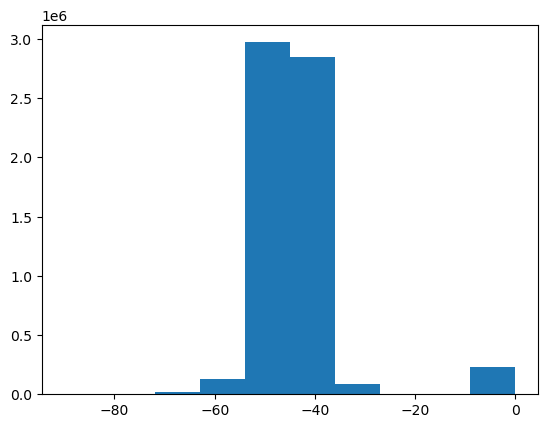

In [18]:
plt.hist(ds.rsl.fillna(0).values.ravel())

(array([1.221000e+03, 5.020000e+03, 1.619300e+04, 1.328410e+05,
        2.971333e+06, 2.848394e+06, 8.541600e+04, 0.000000e+00,
        0.000000e+00, 2.302300e+05]),
 array([-90., -81., -72., -63., -54., -45., -36., -27., -18.,  -9.,   0.]),
 <BarContainer object of 10 artists>)

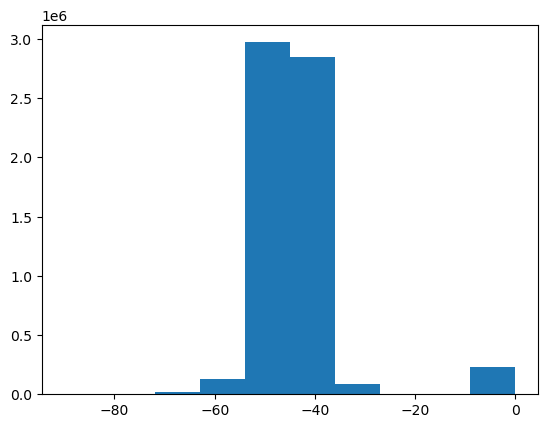

In [19]:
plt.hist(ds_linkbylink.rsl.fillna(0).values.ravel())

### 5) test memory usage 

In [20]:
# the advantage of linkbylink is that it uses less memory 
# this is because linkbylink allocates the memory onece and then reads chunk by chunk from harddrive
# whereas the xarray way of reshaping arrays seems to create a new one in memory, leading to twise as much
# memory consumption. 

# however, reading all this data to memory is slow and maybe not realistic, unless for very interested people

In [21]:
# takes long time to run. but manages
#%%time
#ds_linkbylink = oddt.transform_andersson_2022_OpenMRG_linkbylink(
#    fn='data/andersson_2022_OpenMRG/OpenMRG.zip', 
#    path_to_extract_to='data/andersson_2022_OpenMRG/',
#    time_start_end = ('2015-06-28T00', '2015-07-29T00'), # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
#    restructure_data=True,
#    resample_1min=False
#)

In [ ]:
# crashes (on limitied ram)
ds = oddt.transform_andersson_2022_OpenMRG(
    fn='andersson_2022_OpenMRG/OpenMRG.zip', 
    path_to_extract_to='data/andersson_2022_OpenMRG/',
    time_start_end = ('2015-06-28T00', '2015-08-29T00'), # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)